In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [34]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [67]:
input_location = 'KTH-io-aware-filter'
files_prefix = ''
# schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-1', 'maxsort-1', 'balance-12-ratio-1', 'balance-11-largest-1', 'balance-12-smallest-1']
# schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-15-1', 'maxutil-comp-2-2-1', 'maxutil-comp-5-5-1', 'plan-1', 'plan-0']
# schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1', 'maxutil-opt-15-1', 'maxutil-opt-20-1', 'plan-opt-sum-1', 'window-10-10-1']
schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1', 'plan-opt-sum-1', 'plan-opt-square-0', 'plan-opt-start-1', 'window-10-10-1']
# schedule_names = ['filler', 'backfill-0', 'backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-0', 'maxutil-opt-10-1', 'window-10-10-1']

In [68]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware-filter/backfill-0_schedule.csv', '../output/KTH-io-aware-filter/backfill-1_schedule.csv', '../output/KTH-io-aware-filter/backfill-sjf-1_schedule.csv', '../output/KTH-io-aware-filter/filler_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-0_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-15-1_schedule.csv', '../output/KTH-io-aware-filter/maxutil-opt-20-1_schedule.csv', '../output/KTH-io-aware-filter/plan-opt-square-0_schedule.csv', '../output/KTH-io-aware-filter/plan-opt-start-1_schedule.csv', '../output/KTH-io-aware-filter/plan-opt-sum-1_schedule.csv', '../output/KTH-io-aware-filter/window-10-10-1_schedule.csv']
['../output/KTH-io-aware-filter/backfill-0_jobs.csv', '../output/KTH-io-aware-filter/backfill-1_jobs.csv', '../output/KTH-io-aware-filter/backfill-sjf-1_jobs.csv', '../output/KTH-io-aware-filter/filler_jobs.csv', '../output/KTH-io-aware-filter/maxutil-opt-10-0_jobs.csv'

In [69]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 backfill-sjf-1
 maxutil-opt-10-1
 plan-opt-square-0
 plan-opt-start-1
 plan-opt-sum-1
 window-10-10-1


In [70]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 backfill-sjf-1
 maxutil-opt-10-1
 plan-opt-square-0
 plan-opt-start-1
 plan-opt-sum-1
 window-10-10-1


In [71]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [72]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [73]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [74]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=600)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [75]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [76]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [77]:
metrics.T

,backfill-1,backfill-sjf-1,maxutil-opt-10-1,plan-opt-sum-1,plan-opt-square-0,plan-opt-start-1,window-10-10-1
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0
makespan,2.87862e+07,2.88433e+07,2.88168e+07,2.88379e+07,2.87936e+07,2.88092e+07,2.88047e+07
max_slowdown,1.00024,1.00022,1.00023,1.00023,1.00023,1.00024,1.00024
max_turnaround_time,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975911,0.975913,0.97591,0.975911,0.975916,0.975912,0.975905
mean_turnaround_time,223.917,223.878,224.061,223.901,223.782,223.933,224.378
mean_waiting_time,0,0,0,0,0,0,0
nb_computing_machines,109,109,109,109,109,109,109


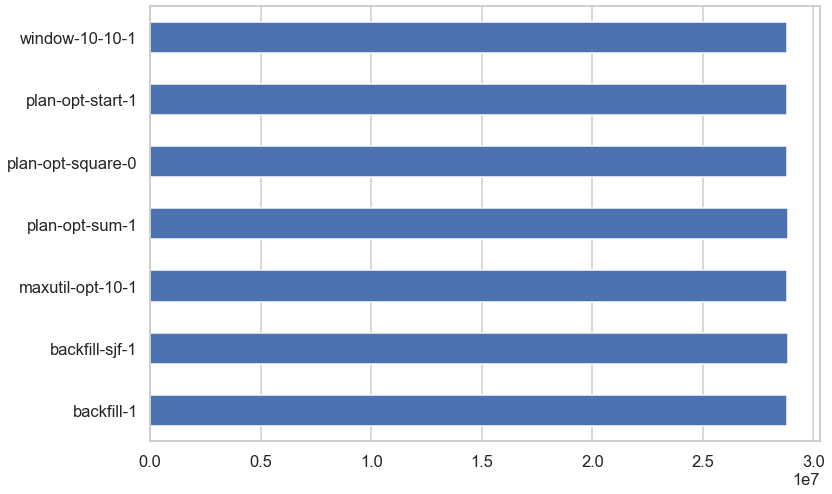

In [78]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

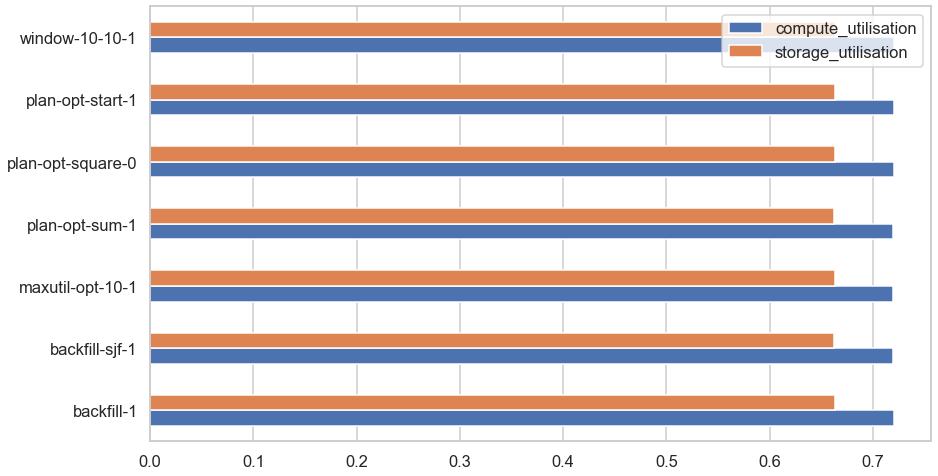

In [79]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [80]:
metrics_df = create_all_metrics_df()

In [81]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,backfill-1,backfill-sjf-1,maxutil-opt-10-1,plan-opt-sum-1,plan-opt-square-0,plan-opt-start-1,window-10-10-1
count,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04,28453.000000,28453.000000
mean,14561.065035,13909.254387,13574.848908,13670.496339,1.106503e+04,13708.940257,14050.397103
std,40986.225159,44828.083931,41692.253922,42631.737889,4.176127e+04,42184.639452,43198.276905
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.000002
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.241377,0.000000,0.000000,93.739473,5.871158e+01,68.821529,0.000000
75%,9314.759640,5567.048777,7122.267274,6976.340839,5.426275e+03,6650.576586,6331.163876
max,660955.100730,637068.798290,721272.804758,610118.897082,1.340607e+06,654159.259280,656130.430363


(0.0, 1000000.0)

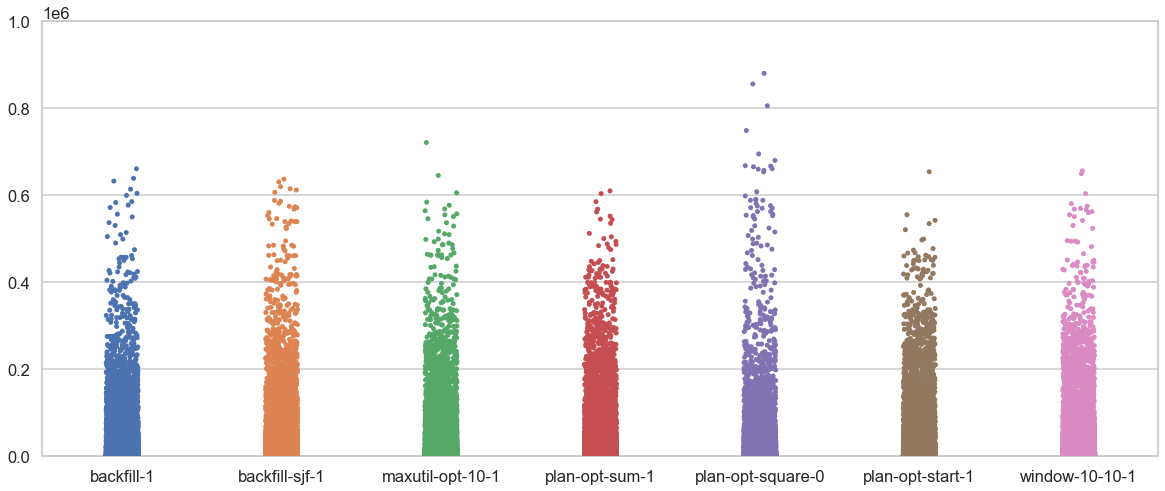

In [82]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0, 10**6)

<AxesSubplot:>

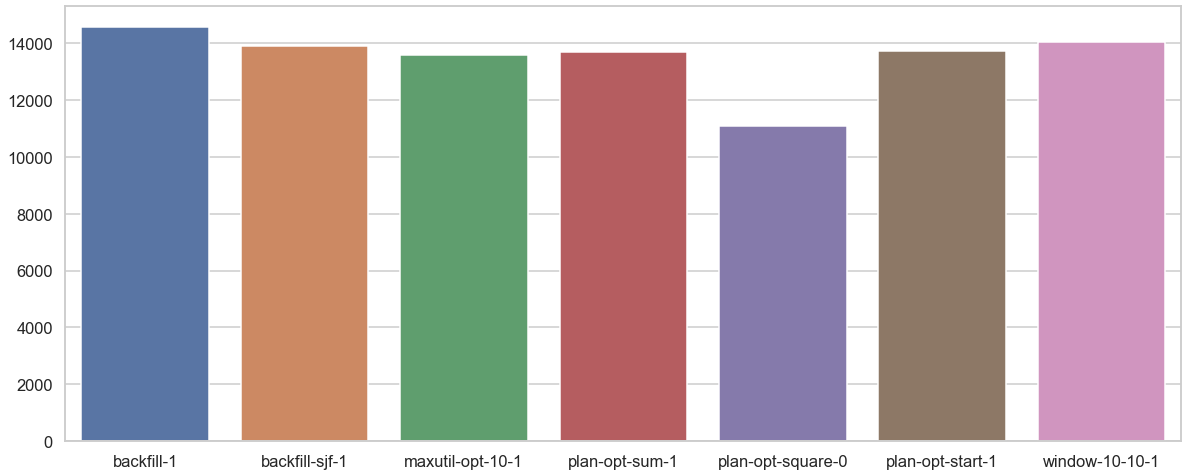

In [83]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)

<AxesSubplot:>

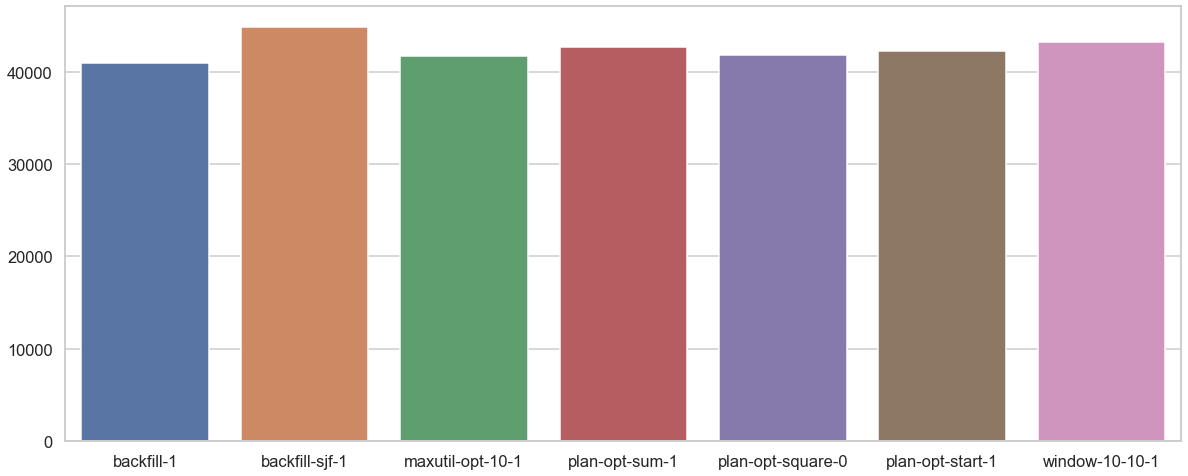

In [84]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, estimator=np.std, ci=None, ax=ax)

(0.0, 24424.577253398114)

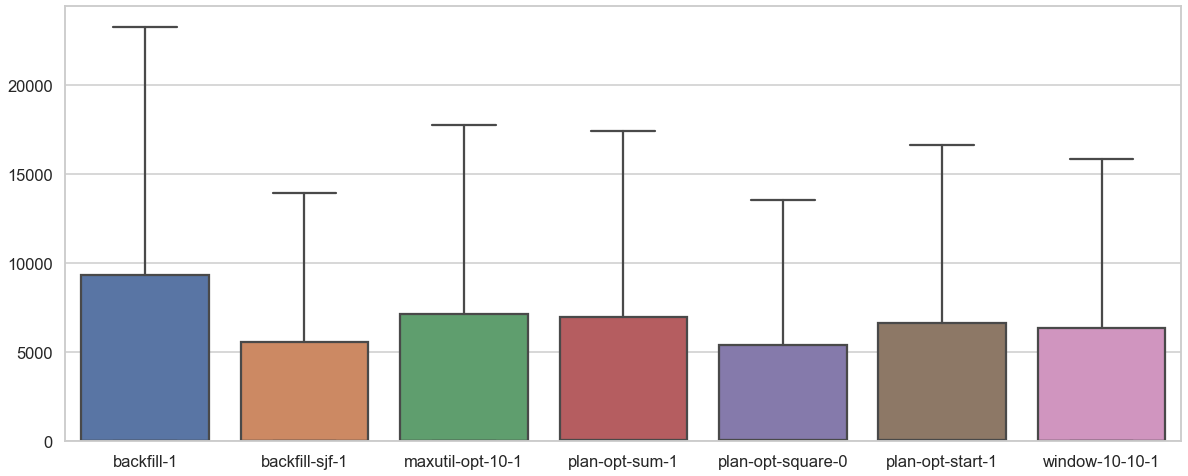

In [85]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=waiting_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [86]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,backfill-1,backfill-sjf-1,maxutil-opt-10-1,plan-opt-sum-1,plan-opt-square-0,plan-opt-start-1,window-10-10-1
count,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04,28453.000000,28453.000000
mean,23345.399482,22694.049249,22360.368926,22455.464866,1.984946e+04,22494.067785,22835.114044
std,48033.555144,51779.385912,48486.659985,50241.561033,5.018029e+04,49835.219430,50198.239102
min,0.090400,0.090400,0.196674,0.090400,1.998960e-01,0.166378,0.090400
25%,177.306547,117.738795,164.362575,166.467714,1.632659e+02,154.119126,125.920700
50%,5973.278602,4347.495695,5214.765775,4865.540654,4.443692e+03,4733.324446,4664.015824
75%,23951.637759,18738.767134,21470.956454,20212.937847,1.785824e+04,20344.293009,21019.131199
max,676106.711923,674253.910261,731807.102456,647326.569868,1.380499e+06,664693.556979,693334.443739


(0.0, 1000000.0)

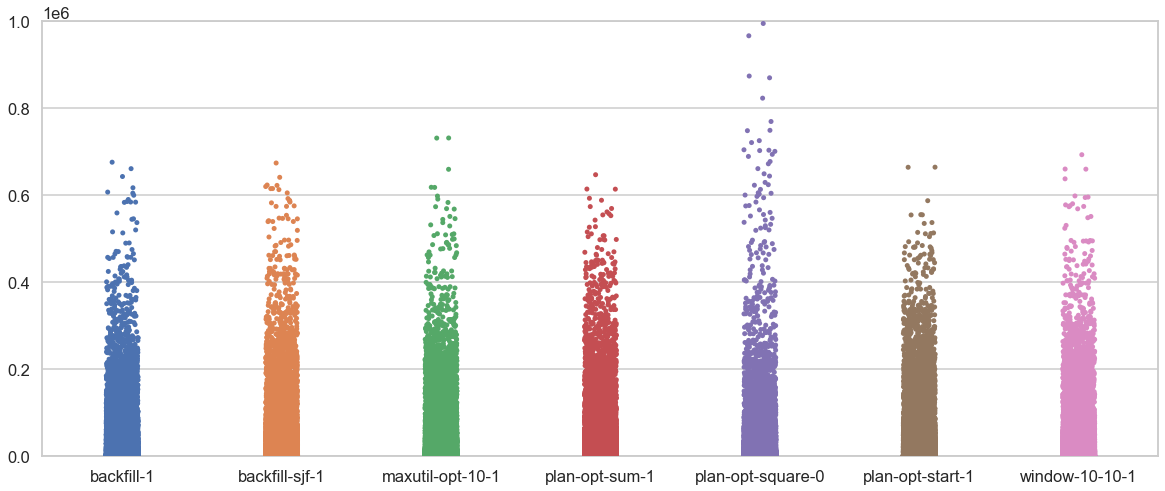

In [87]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0,10**6)

<AxesSubplot:>

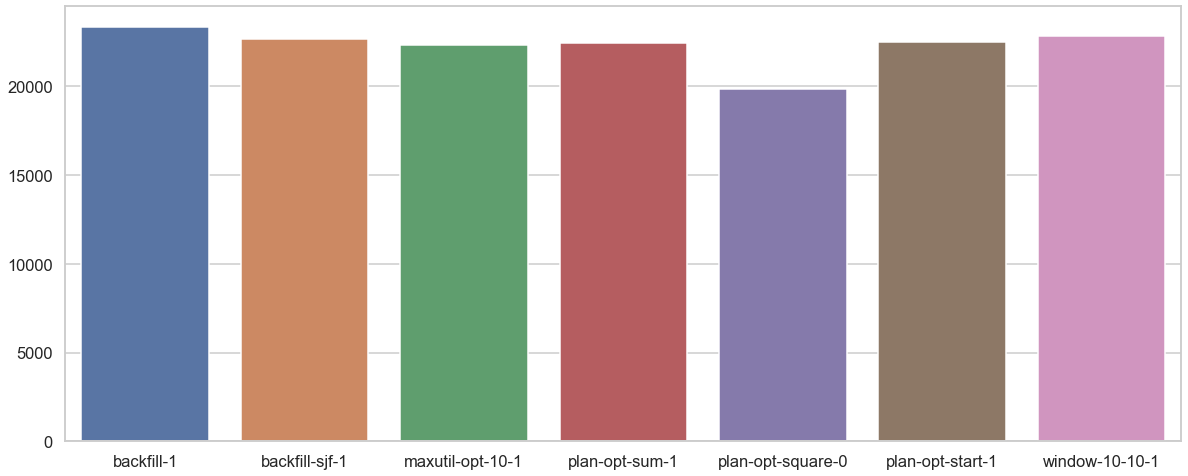

In [88]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)

<AxesSubplot:>

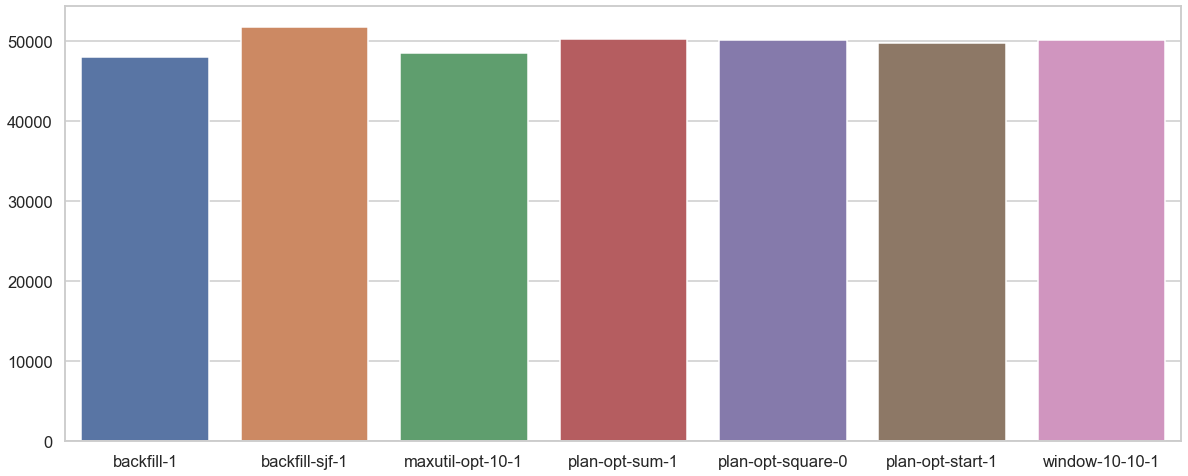

In [89]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, estimator=np.std, ci=None, ax=ax)

(0.0, 62569.4728409505)

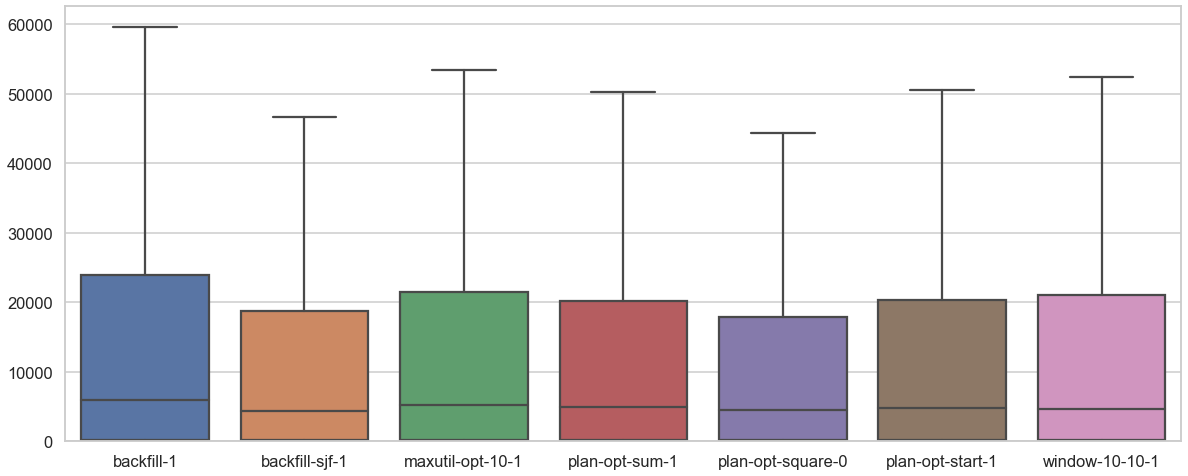

In [90]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=turnaround_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [91]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,backfill-1,backfill-sjf-1,maxutil-opt-10-1,plan-opt-sum-1,plan-opt-square-0,plan-opt-start-1,window-10-10-1
count,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,181.475132,109.501551,163.732592,131.839186,105.808894,131.756090,136.425741
std,1123.992847,725.026637,2128.210454,1668.094562,1419.005706,1125.447359,980.590019
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.002834,1.000000,1.000000,1.041655,1.020529,1.027543,1.000000
75%,6.790060,4.401651,5.777690,5.510831,4.777497,5.348180,4.694154
max,72686.529312,48479.460646,250145.356847,245622.334341,181986.004396,92121.234375,84824.142432


(0.0, 200000.0)

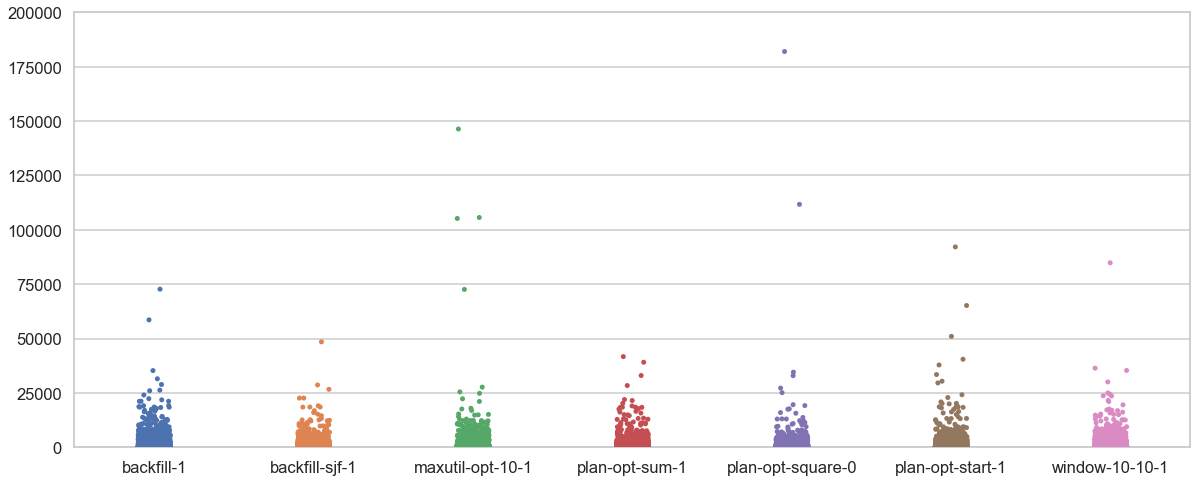

In [92]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0, 0.2*10**6)

<AxesSubplot:>

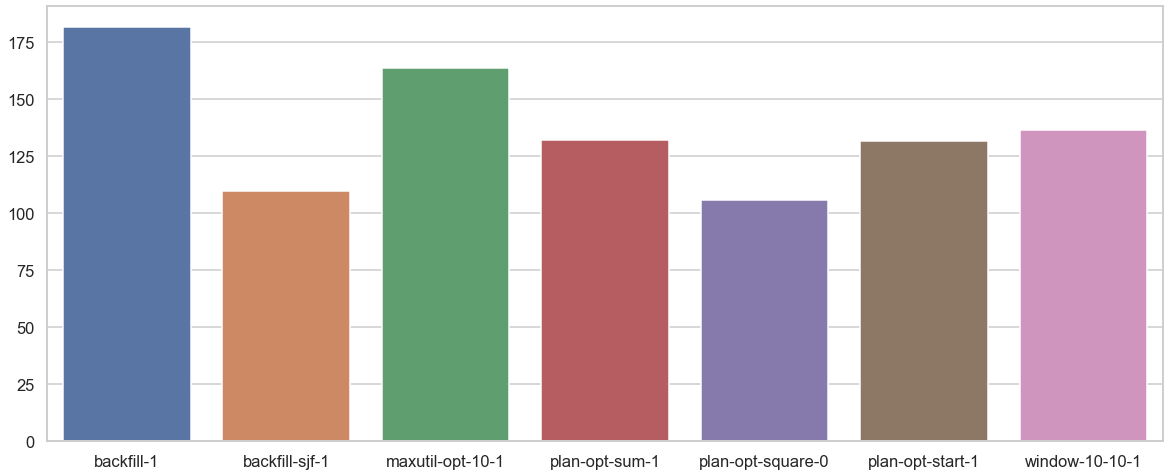

In [93]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, ci=None, ax=ax)

<AxesSubplot:>

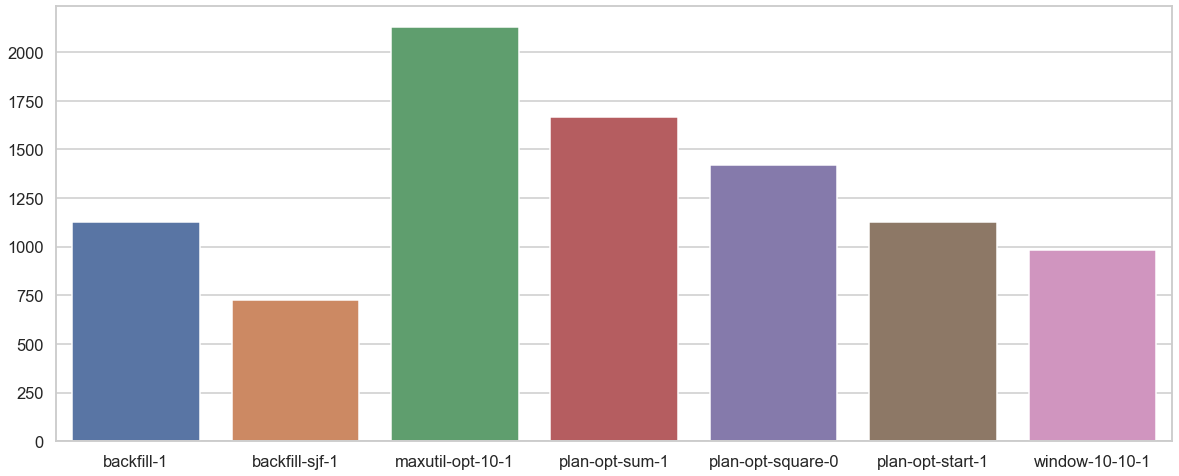

In [94]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, estimator=np.std, ci=None, ax=ax)

(0.0, 16.173475415284035)

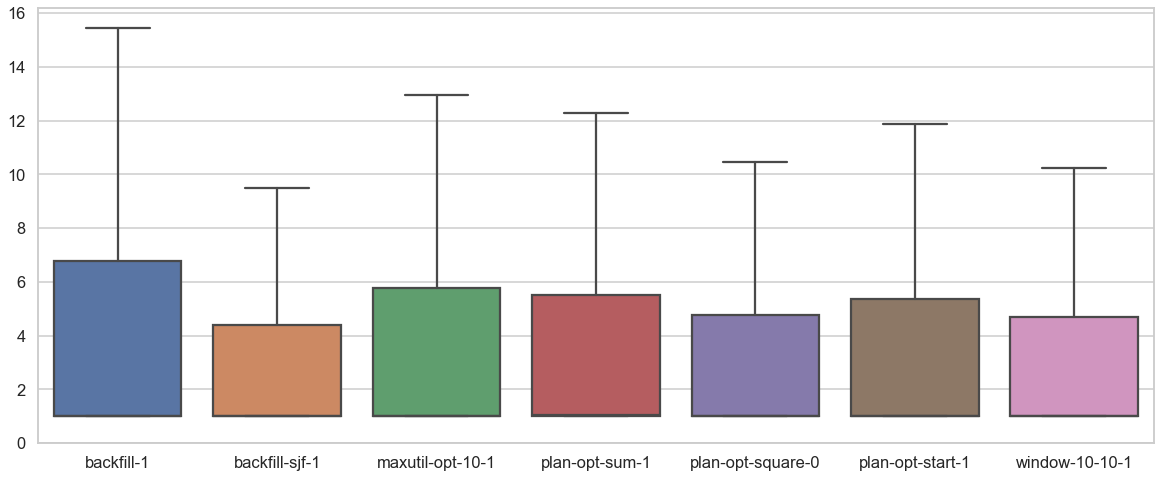

In [95]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=slowdown, showfliers=False, ax=ax)
ax.set_ylim(0)

(0.0, 1311.4374932180006)

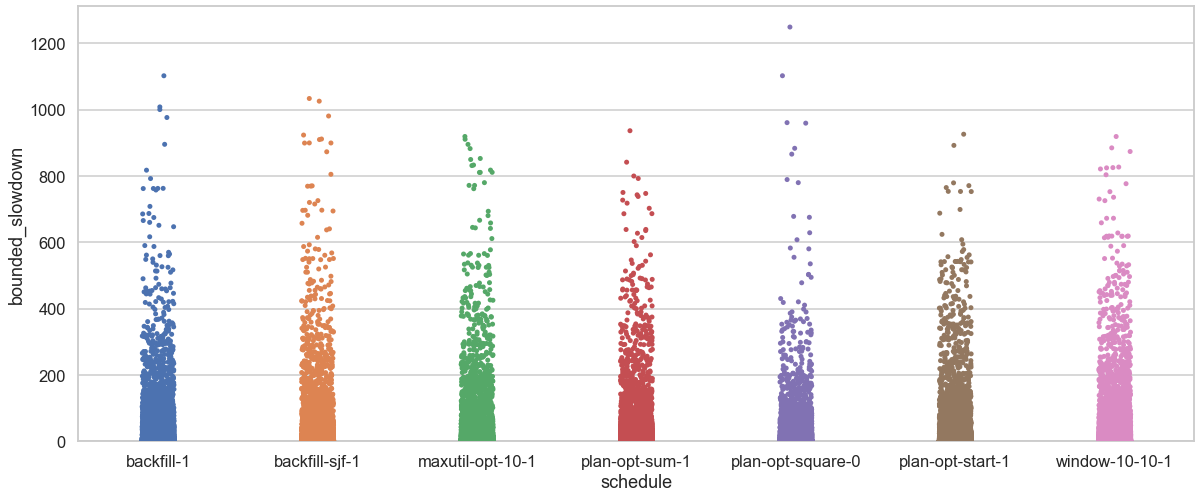

In [96]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
ax.set_ylim(0)

<AxesSubplot:xlabel='schedule', ylabel='bounded_slowdown'>

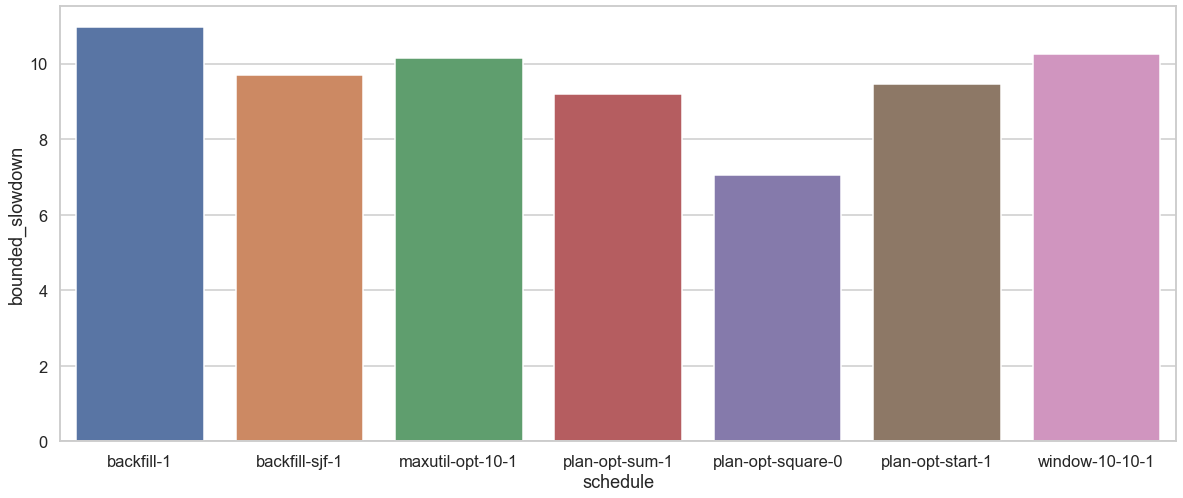

In [97]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ci=None, ax=ax)

<AxesSubplot:xlabel='schedule', ylabel='bounded_slowdown'>

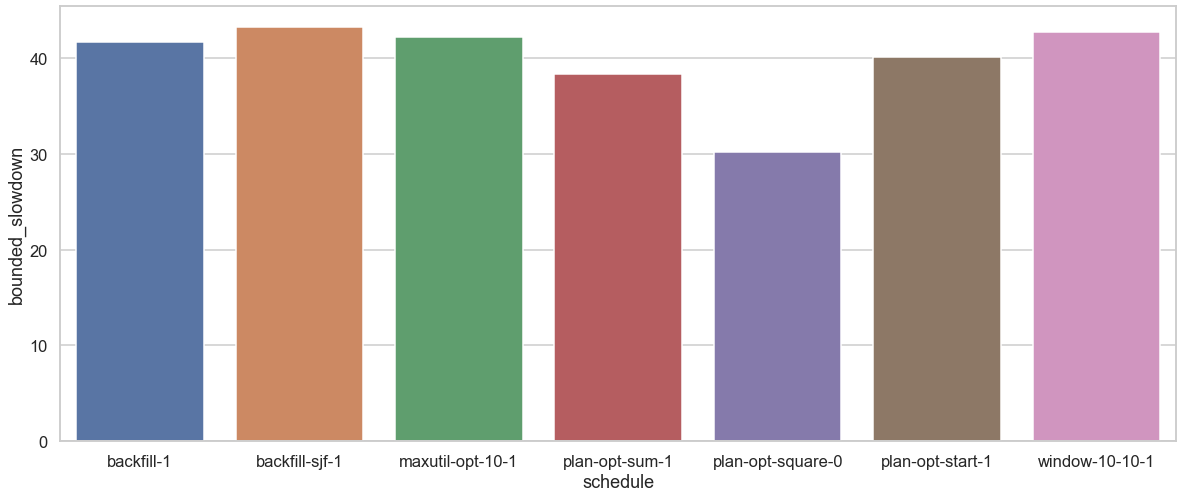

In [98]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', estimator=np.std, ci=None, ax=ax)

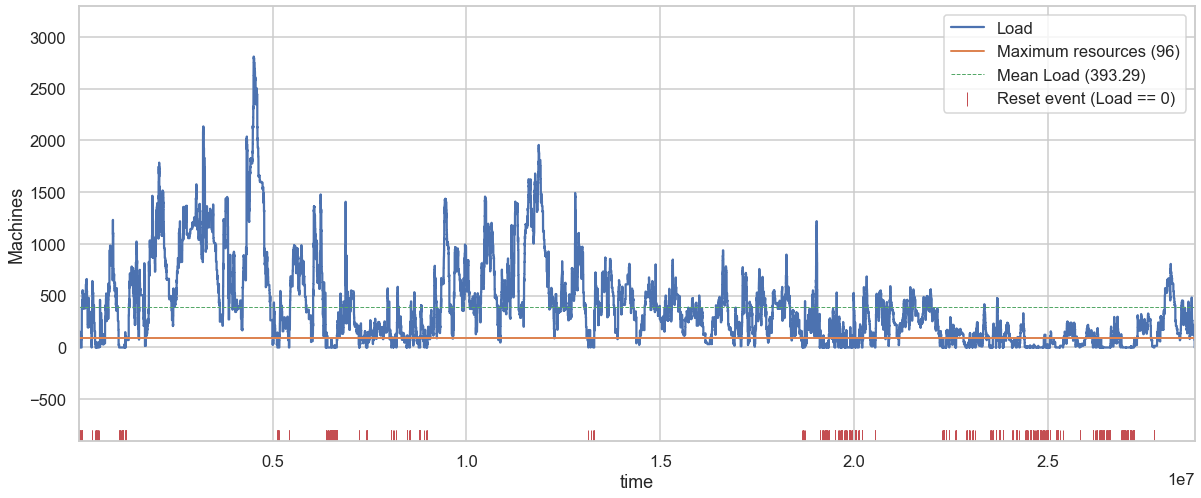

In [39]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

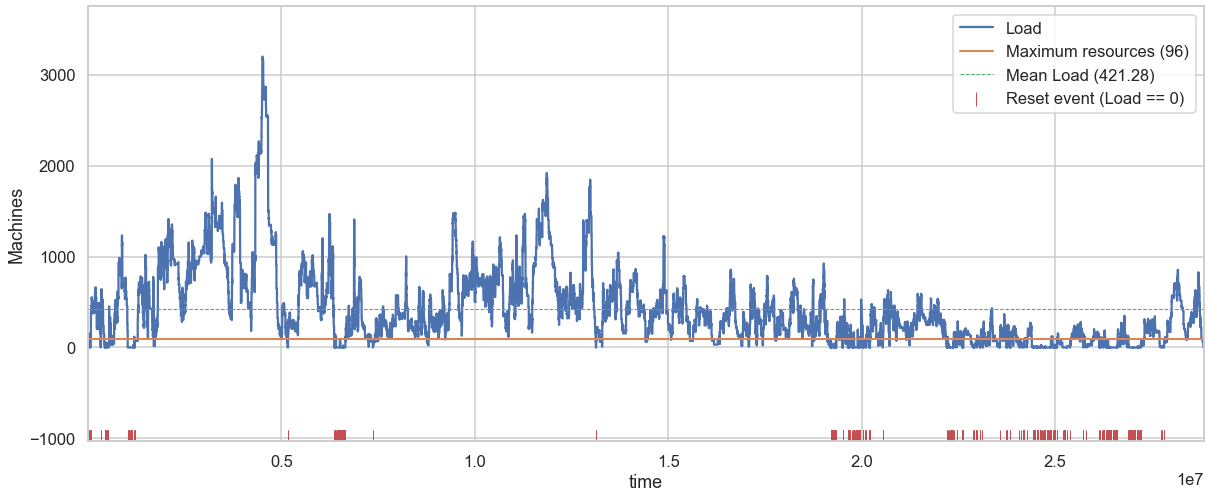

In [67]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-sjf-1'].queue, nb_resources=96, ax=ax)

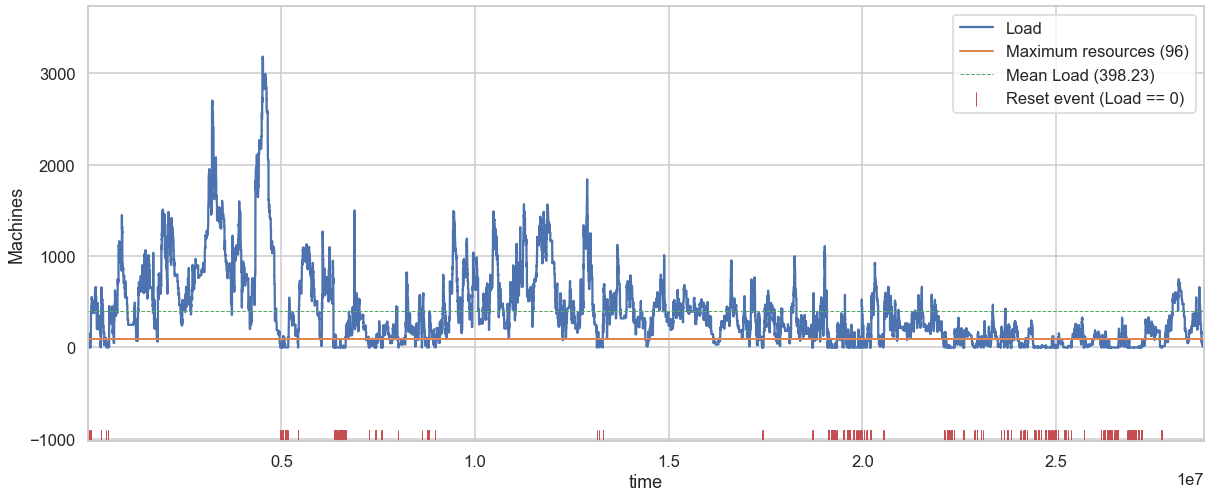

In [40]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['maxutil-opt-10-1'].queue, nb_resources=96, ax=ax)